In [3]:
import pandas as pd

df_embeds = pd.read_parquet('data/username_weighted_embeds.parquet')
df_train_all = pd.read_parquet('data/training-dataset.parquet')

In [8]:
from sklearn.preprocessing import LabelEncoder, TargetEncoder
from sklearn.model_selection import train_test_split

df_train = df_train_all[['username','category_enum','label']]
df_train = df_train.dropna(subset=['label'])
df_train = df_train.drop(columns=['username'])


labels = ['entertainment', 'food', 'travel', 'health and lifestyle', 'mom and children', 'fashion', 'tech', 'sports', 'art', 'gaming']

label_encoder = LabelEncoder()
label_encoder.fit(labels)

df_train['target'] = label_encoder.transform(df_train['label'])
df_train = df_train.drop(columns=['label'])


X = df_train.drop(columns=['target'])
y = df_train[['target']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


encoder = TargetEncoder()
cat_encoded_train = encoder.fit_transform(X_train["category_enum"].to_numpy().reshape(-1,1), y_train['target'].tolist())
X_train['category_encoded'] = [row.tolist() for row in cat_encoded_train]
X_train = pd.DataFrame(X_train['category_encoded'].tolist())


cat_encoded_test = encoder.transform(X_test['category_enum'].to_numpy().reshape(-1,1))
X_test['category_encoded'] = [row.tolist() for row in cat_encoded_test]
X_test = pd.DataFrame(X_test['category_encoded'].tolist())

X_test
#X_train, X_test, y_train, y_test = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()



,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.000000,0.078723,0.080624,0.0,0.000000,0.000000,0.000000,0.788303,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000
2,0.048629,0.065025,0.376826,0.334962,0.0,0.032767,0.016315,0.016285,0.065079,0.032647
3,0.237609,0.525163,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.0,0.382773,0.000000,0.315249,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
544,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000
545,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
546,0.027634,0.217040,0.068868,0.272297,0.0,0.151082,0.054762,0.041070,0.068969,0.096014
547,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000


In [11]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report



model = XGBClassifier(
    objective='multi:softmax',
    num_class=10,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=1,
    n_estimators=500,
    colsample_bytree=0.8,              
    subsample=0.85,
    device='cuda',
    random_state=42,
    eval_metric=['mlogloss', 'merror'],  # Add metrics to track
    early_stopping_rounds=10  # Optional: stop if no improvement
)



model.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=True
)

y_pred = model.predict(X_test)

[0]	validation_0-mlogloss:2.22598	validation_0-merror:0.47491	validation_1-mlogloss:2.23208	validation_1-merror:0.54463
[1]	validation_0-mlogloss:2.16115	validation_0-merror:0.45484	validation_1-mlogloss:2.17594	validation_1-merror:0.52277
[2]	validation_0-mlogloss:2.10930	validation_0-merror:0.45484	validation_1-mlogloss:2.13149	validation_1-merror:0.49180
[3]	validation_0-mlogloss:2.05143	validation_0-merror:0.45255	validation_1-mlogloss:2.08151	validation_1-merror:0.49909
[4]	validation_0-mlogloss:2.00671	validation_0-merror:0.44982	validation_1-mlogloss:2.04219	validation_1-merror:0.49545
[5]	validation_0-mlogloss:1.96041	validation_0-merror:0.44845	validation_1-mlogloss:2.00114	validation_1-merror:0.49362
[6]	validation_0-mlogloss:1.91761	validation_0-merror:0.44571	validation_1-mlogloss:1.96457	validation_1-merror:0.49727
[7]	validation_0-mlogloss:1.87944	validation_0-merror:0.44708	validation_1-mlogloss:1.93288	validation_1-merror:0.50091
[8]	validation_0-mlogloss:1.84476	valida


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.37      0.41        38
           1       0.43      0.34      0.38        59
           2       0.46      0.56      0.50        55
           3       0.55      0.74      0.63       114
           4       0.00      0.00      0.00         5
           5       0.55      0.57      0.56        96
           6       0.43      0.09      0.15        34
           7       0.88      0.52      0.65        27
           8       0.36      0.42      0.39        59
           9       0.59      0.56      0.58        62

    accuracy                           0.51       549
   macro avg       0.47      0.42      0.43       549
weighted avg       0.51      0.51      0.50       549


Additional Metrics:
Accuracy: 0.5118
Macro F1: 0.4252
Weighted F1: 0.4966
Macro Precision: 0.4712
Macro Recall: 0.4176


/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: 

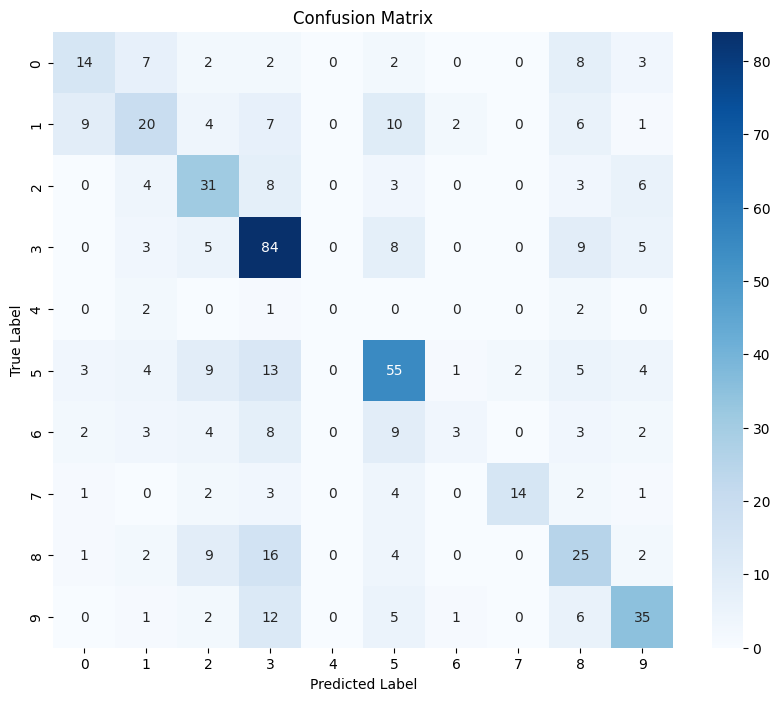

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Print detailed metrics
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')

print("\nAdditional Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



In [45]:
# Print confusion details
cm = confusion_matrix(y_test, y_pred)
class_confusion = []

for i in range(len(cm)):
    misclassified = sum(cm[i]) - cm[i][i]  # total - correct predictions
    accuracy = cm[i][i] / sum(cm[i])
    class_confusion.append((i, misclassified, accuracy))

# Sort by number of misclassifications
class_confusion.sort(key=lambda x: x[1], reverse=True)

print("\nClass-wise Analysis:")
for class_idx, misclassified, accuracy in class_confusion:
    print(f"Class {class_idx}: Accuracy={accuracy:.2f}, Misclassified={misclassified}")


Class-wise Analysis:
Class 1: Accuracy=0.45, Misclassified=35
Class 5: Accuracy=0.72, Misclassified=28
Class 0: Accuracy=0.29, Misclassified=27
Class 2: Accuracy=0.65, Misclassified=21
Class 6: Accuracy=0.30, Misclassified=21
Class 9: Accuracy=0.68, Misclassified=19
Class 8: Accuracy=0.74, Misclassified=18
Class 3: Accuracy=0.86, Misclassified=14
Class 7: Accuracy=0.48, Misclassified=12
Class 4: Accuracy=0.00, Misclassified=3
